In [1]:
# Python packages
import scanpy as sc
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is dep

In [2]:
%%R
library(Seurat)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
rgeos version: 0.6-4, (SVN revision 699)
 GEOS runtime version: 3.12.0-CAPI-1.18.0 
 Please note that rgeos will be retired during October 2023,
plan transition to sf or terra functions using GEOS at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html for details.
 GEOS using OverlayNG
 Linking to sp version: 2.0-0 
 Polygon checking: TRUE 

Attaching SeuratObject
Attaching sp


In [3]:
# wget -c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad.gz
adata_raw = sc.read_h5ad(
    "dataset/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad",
)
adata_raw.layers["logcounts"] = adata_raw.X
adata_raw

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_io/specs/registry.py:235: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_pct_counts_mt' was written without encoding metadata.
  return func(*args, **kwargs)
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_n_counts' was written without encoding metadata.
  return func(*args, **kwargs)
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_n_genes' was written without encoding metadata.
  return func(*args, **kwargs)
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_io/utils.py:202: OldFormatWarning: Element '/obs/GEX_size_factors' was written without 

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

In [4]:
label_key = "cell_type"
batch_key = "batch"

In [5]:
#   look at the different batches and how many cells we have for each
adata_raw.obs[batch_key].value_counts()

s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: batch, dtype: int64

In [6]:
# For simplicity, and to reduce computational time, we will select three samples to use.
keep_batches = ["s1d3", "s2d1", "s3d7"]
adata = adata_raw[adata_raw.obs[batch_key].isin(keep_batches)].copy()
adata

AnnData object with n_obs × n_vars = 10270 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

In [7]:
# look at the feature types
adata.var["feature_types"].value_counts()

ATAC    116490
GEX      13431
Name: feature_types, dtype: int64

In [8]:
# subset to only the gene expression features
adata = adata[:, adata.var["feature_types"] == "GEX"].copy()
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

In [9]:
# re-normalise the data bacause of the subsetting
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

# Unintegrated data

In [10]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

# it might even suggest that integration is not required if samples already overlap

AnnData object with n_obs × n_vars = 10270 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


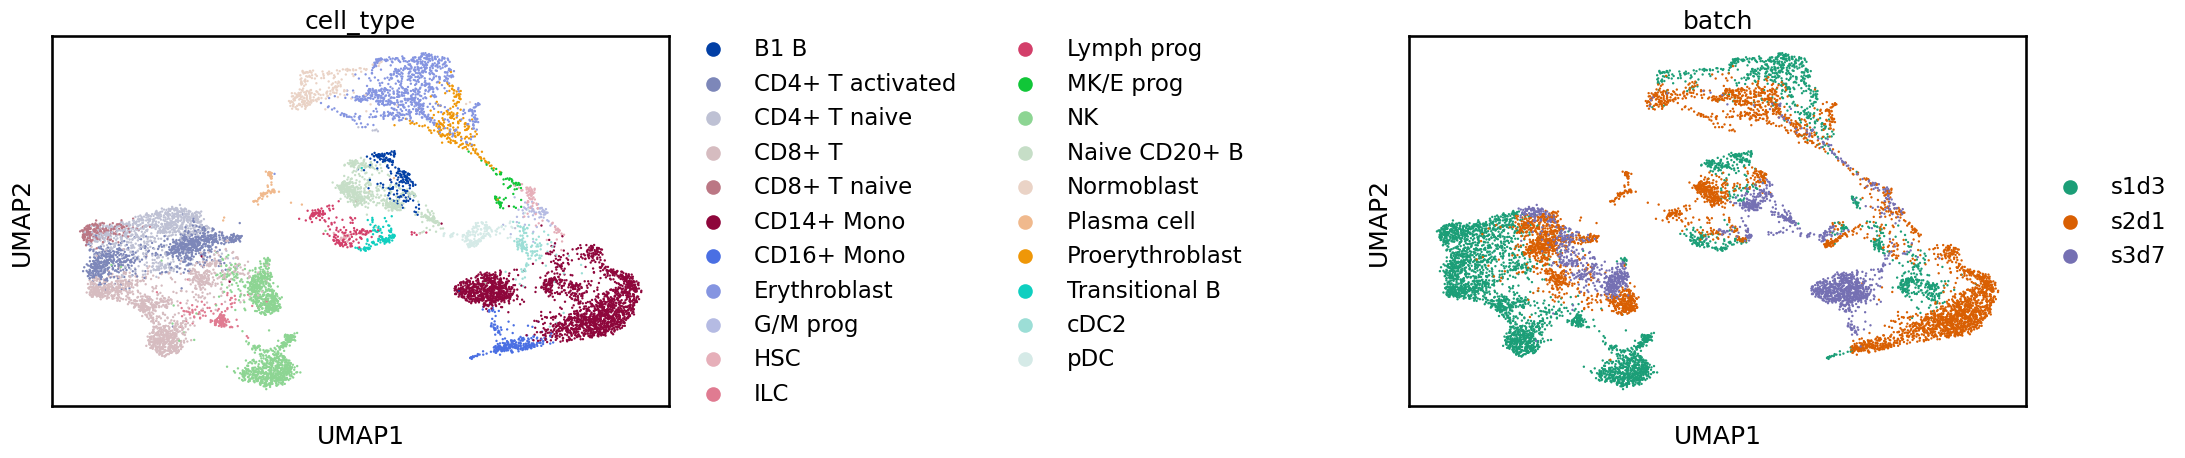

In [11]:
adata.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]  # Set custom colours for batches
sc.pl.umap(adata, color=[label_key, batch_key], wspace=1)

# Batch-aware feature selection

Get adata_hvg

In [12]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
    # people typically use between 1000 and 6000 HVGs in a standard analysis. 
    # While selecting fewer genes can aid in the removal of batch effects
)
adata
adata.var

,feature_types,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
AL627309.5,GEX,ENSG00000241860,112,False,0.006533,0.775289,0.357974,1,False
LINC01409,GEX,ENSG00000237491,422,False,0.024462,0.716935,-0.126119,0,False
LINC01128,GEX,ENSG00000228794,569,False,0.030714,0.709340,-0.296701,0,False
NOC2L,GEX,ENSG00000188976,675,False,0.037059,0.704363,-0.494025,0,False
KLHL17,GEX,ENSG00000187961,88,False,0.005295,0.721757,-0.028456,0,False
...,...,...,...,...,...,...,...,...,...
MT-ND5,GEX,ENSG00000198786,4056,False,0.269375,0.645837,-0.457491,0,False
MT-ND6,GEX,ENSG00000198695,1102,False,0.051506,0.697710,-0.248421,0,False
MT-CYB,GEX,ENSG00000198727,5647,False,0.520368,0.613233,-0.441362,0,False
AL592183.1,GEX,ENSG00000273748,732,False,0.047486,0.753417,0.413699,0,False


0    9931
1    1824
2     852
3     824
Name: highly_variable_nbatches, dtype: int64

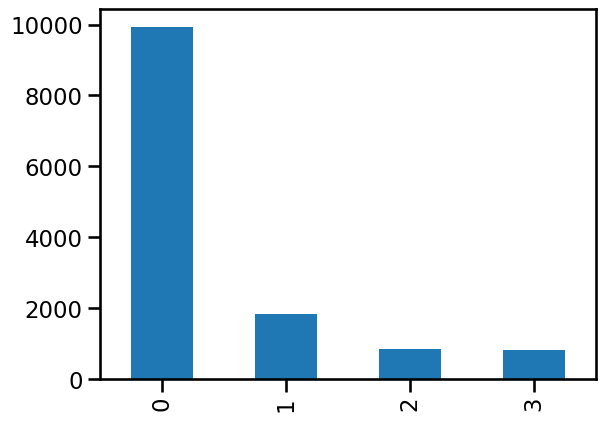

In [13]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [14]:
# create an object with just the selected genes to use for integration
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'co

# Variational autoencoder (VAE) based integration

When performing integration with scVI we pretended that we didn’t already have any cell labels

In [15]:
adata_scvi = adata_hvg.copy()

In [16]:
# the input expression matrix containing unnormalised count data
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

I0000 00:00:1695301384.775856 1282811 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pc

In [17]:
# Building the model
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [18]:
# more detailed description of the model
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   3   │
│         n_cells          │ 10270 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d3    │          0          │
│                    │    s2d1    │          1          │
│                    │    s3d7    │          2          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [19]:
# Training the model
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

400

In [20]:
model_scvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [05:44<00:00,  1.17it/s, v_num=1, train_loss_step=610, train_loss_epoch=645]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:44<00:00,  1.16it/s, v_num=1, train_loss_step=610, train_loss_epoch=645]


In [21]:
# Extracting the embedding
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [22]:
# Calculate a batch-corrected UMAP
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pc

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


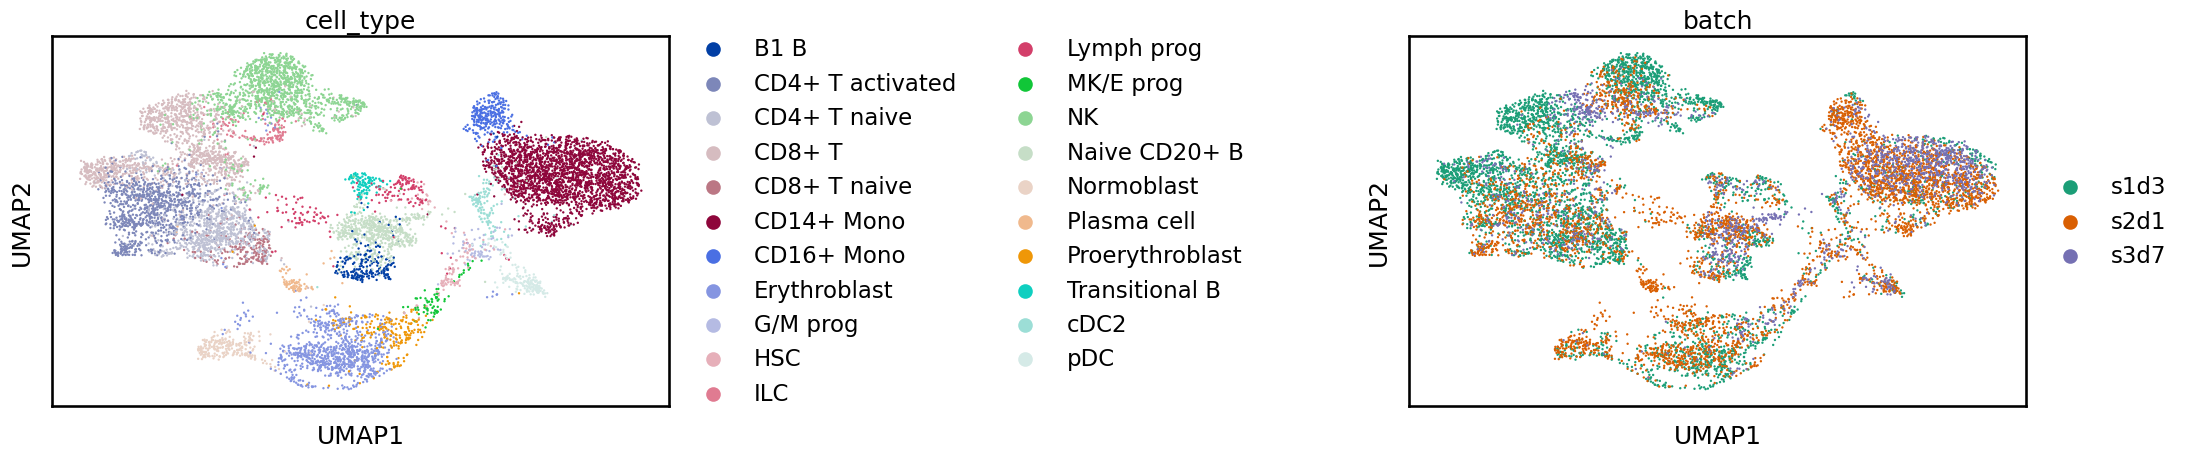

In [23]:
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)
# In many cases, we would not already have identity labels so from this stage 
# we would continue with clustering, annotation and further analysis.

# VAE integration using cell labels

 While this scenario is common there are some cases where we do know something about cell identity in advance

In [24]:
# Normally we would need to run scVI first but we have already done that here
# model_scvi = scvi.model.SCVI(adata_scvi) etc.
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key=label_key, unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.0.3.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'cell_type',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   3   │
│         n_cells          │ 10270 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  22   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d3    │          0          │
│                    │    s2d1    │          1          │
│                    │    s3d7    │          2          │
└────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │       B1 B       │          0          │
│                        │ CD4+ T activated │          1          │
│                        │   CD4+ T naive   │          2          │
│                        │      CD8+ T      │          3          │
│                        │   CD8+ T naive   │          4          │
│                        │    CD14+ Mono    │          5          │
│                        │    CD16+ Mono    │          6          │
│                        │   Erythroblast   │          7          │
│                        │     G/M prog     │          8          │
│                        │       HSC        │          9          │
│                        │       ILC        │         10          │
│                        │    Lymph prog    │         11          │
│                        │    MK/E prog     │         12          │
│                        │        NK        │         13          │
│                        │  Naive CD20+ B   │         14          │
│                        │    Normoblast    │         15          │
│                        │   Plasma cell    │         16          │
│                        │ Proerythroblast  │         17          │
│                        │  Transitional B  │         18          │
│                        │       cDC2       │         19          │
│                        │       pDC        │         20          │
│                        │    unlabelled    │         21          │
└────────────────────────┴──────────────────┴─────────────────────┘

In [25]:
# Note that this is much fewer than before as we are just refining the scVI model
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)

INFO     Training for 10 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it, v_num=1, train_loss_step=885, train_loss_epoch=742]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it, v_num=1, train_loss_step=885, train_loss_epoch=742]


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


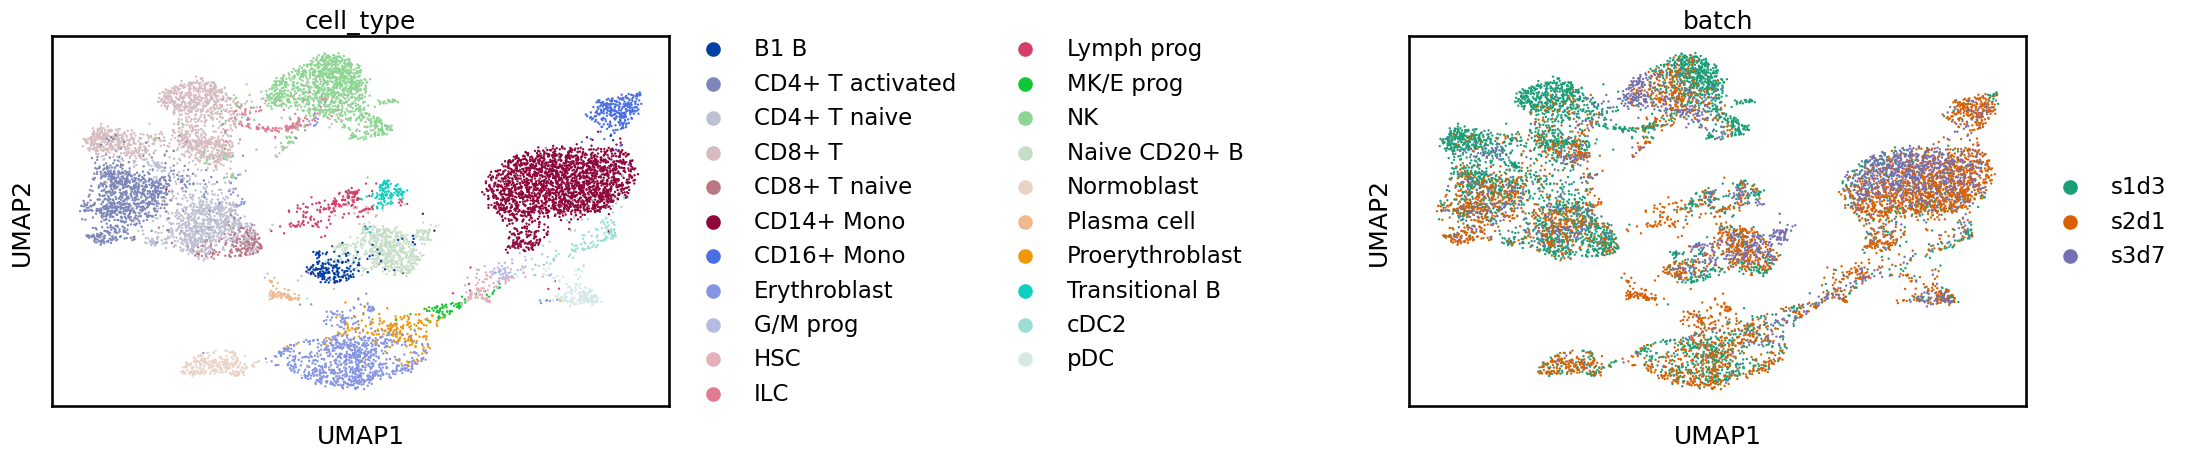

In [26]:
adata_scanvi = adata_scvi.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=[label_key, batch_key], wspace=1)

# Graph-based integration

In [27]:
# An important parameter for BBKNN is the number of neighbors per batch. 
# A suggested heuristic for this is to use 25 if there are more than 100,000 cells or the default of 3 if there are fewer than 100,000.

neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else 3
neighbors_within_batch

3

In [28]:
# BBKNN we first perform a PCA as we would before building a normal KNN graph
# start with the log-normalised expression matrix
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

In [29]:
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'co

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


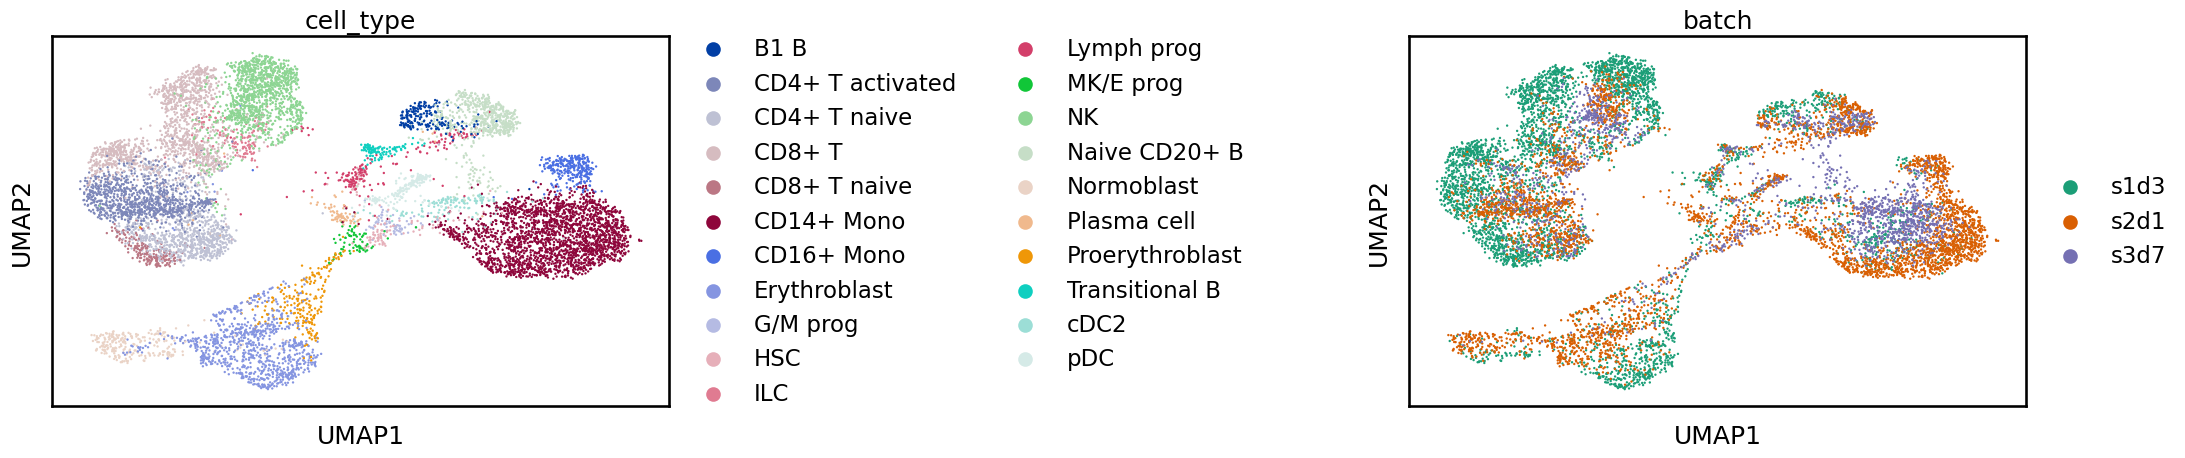

In [30]:
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=[label_key, batch_key], wspace=1)

# Linear embedding integration using Mutual Nearest Neighbors (MNN)

Some downstream applications cannot accept an integrated embedding or neighborhood graph and require a corrected expression matrix. One approach that can produce this output is the integration method in Seurat

In [31]:
adata_seurat = adata_hvg.copy()
# Convert categorical columns to strings
adata_seurat.obs[batch_key] = adata_seurat.obs[batch_key].astype(str)
adata_seurat.obs[label_key] = adata_seurat.obs[label_key].astype(str)
# Delete uns as this can contain arbitrary objects which are difficult to convert
del adata_seurat.uns
adata_seurat

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [32]:
%%R -i adata_seurat
# https://github.com/satijalab/seurat/issues/7581
adata_seurat

class: SingleCellExperiment 
dim: 2000 10270 
metadata(0):
assays(3): X counts logcounts
rownames(2000): GPR153 TNFRSF25 ... TMLHE-AS1 MT-ND3
rowData names(9): feature_types gene_id ... highly_variable_nbatches
  highly_variable_intersection
colnames(10270): TCACCTGGTTAGGTTG-3-s1d3 CGTTAACAGGTGTCCA-3-s1d3 ...
  AGCAGGTAGGCTATGT-12-s3d7 GCCATGATCCCTTGCG-12-s3d7
colData names(28): GEX_pct_counts_mt GEX_n_counts ... QCMeds
  DonorSmoker
reducedDimNames(8): ATAC_gene_activity ATAC_lsi_full ... PCA UMAP
mainExpName: NULL
altExpNames(0):


In [33]:
%%R -i adata_seurat
# conver SingleCellExperiment object to Seurat object
seurat <- as.Seurat(adata_seurat, counts = "counts", data = "logcounts")
seurat

An object of class Seurat 
2000 features across 10270 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning message:
In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.5 GiB


In [34]:
%%R -i batch_key
# Unlike some of the other methods, we have seen which take a single object and a batch key, 
# the Seurat integration functions require a list of objects
batch_list <- SplitObject(seurat, split.by = batch_key)
batch_list

$s1d3
An object of class Seurat 
2000 features across 4279 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP

$s2d1
An object of class Seurat 
2000 features across 4220 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP

$s3d7
An object of class Seurat 
2000 features across 1771 samples within 1 assay 
Active assay: originalexp (2000 features, 0 variable features)
 8 dimensional reductions calculated: ATAC_gene_activity, ATAC_lsi_full, ATAC_lsi_red, ATAC_umap, GEX_X_pca, GEX_X_umap, PCA, UMAP



We can now use this list to find anchors for each pair of datasets. Usually, you would identify batch-aware highly variable genes first (using the `FindVariableFeatures()` and `SelectIntegrationFeatures()` functions) but as we have done that already we tell Seurat to use all the features in the object.

In [35]:
%%R
anchors <- FindIntegrationAnchors(batch_list, anchor.features = rownames(seurat))
anchors

  |                                                  | 0 % ~calculating  

  |+++++++++++++++++                                 | 33% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~01m 26s       |++++++++++++++++++++++++++++++++++                | 67% ~35s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 43s
An AnchorSet object containing 25352 anchors between 3 Seurat objects 
 This can be used as input to IntegrateData.


Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 7195 anchors
Filtering anchors
	Retained 5146 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 4619 anchors
Filtering anchors
	Retained 3588 anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 5575 anchors
Filtering anchors
	Retained 3942 anchors


In [36]:
%%R
integrated <- IntegrateData(anchors)
integrated

An object of class Seurat 
4000 features across 10270 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: originalexp


Merging dataset 3 into 2
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data
Merging dataset 1 into 2 3
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Integrating data


The result is another Seurat object, but notice now that the active assay is called “integrated”. This contains the corrected expression matrix which is the final output of the integration.

In [37]:
%%R -o integrated_expr
# Extract the integrated expression matrix
integrated_expr <- GetAssayData(integrated)
# Make sure the rows and columns are in the same order as the original object
integrated_expr <- integrated_expr[rownames(seurat), colnames(seurat)]
# Transpose the matrix to AnnData format
integrated_expr <- t(integrated_expr)
print(integrated_expr[1:10, 1:10])

10 x 10 sparse Matrix of class "dgCMatrix"
                                                                               
TCACCTGGTTAGGTTG-3-s1d3  .            -0.0005365199  1.032812e-02 -2.653187e-02
CGTTAACAGGTGTCCA-3-s1d3  0.0001382038 -0.1809919971 -1.454901e-02  3.608088e-03
ATTCGTTTCAGTATTG-3-s1d3 -0.0121073023 -0.0634131440  .             2.144075e-02
GGACCGAAGTGAGGTA-3-s1d3  .             .             2.972292e-04  .           
ATGAAGCCAGGGAGCT-3-s1d3 -0.0139047069 -0.0313151283  .             2.239855e-02
AGTGCGGAGTAAGGGC-3-s1d3 -0.0004299226 -0.0002657828  .            -1.871410e-03
CTACCTCAGACACCGC-3-s1d3 -0.0055208624 -0.0398862242  7.182253e-06  8.240405e-03
CTTCAATTCACGAATC-3-s1d3  .            -0.0109928419  .             1.935677e-04
CCATTGTGTAGACAAA-3-s1d3  .             0.0171909653  .             5.711312e-05
CCGTTACTCAATGTGC-3-s1d3  0.0139905522  0.0007981117  2.303345e-03  1.356206e-02
                                                                          
TC

  [[ suppressing 10 column names ‘GPR153’, ‘TNFRSF25’, ‘TNFRSF9’ ... ]]


In [38]:
adata_seurat.X = integrated_expr
adata_seurat.layers["seurat"] = integrated_expr
print(adata_seurat)
adata.X

AnnData object with n_obs × n_vars = 10270 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'seurat'
    obsp: 'distances', 'connectivities'


<10270x13431 sparse matrix of type '<class 'numpy.float32'>'
	with 14348115 stored elements in Compressed Sparse Row format>

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


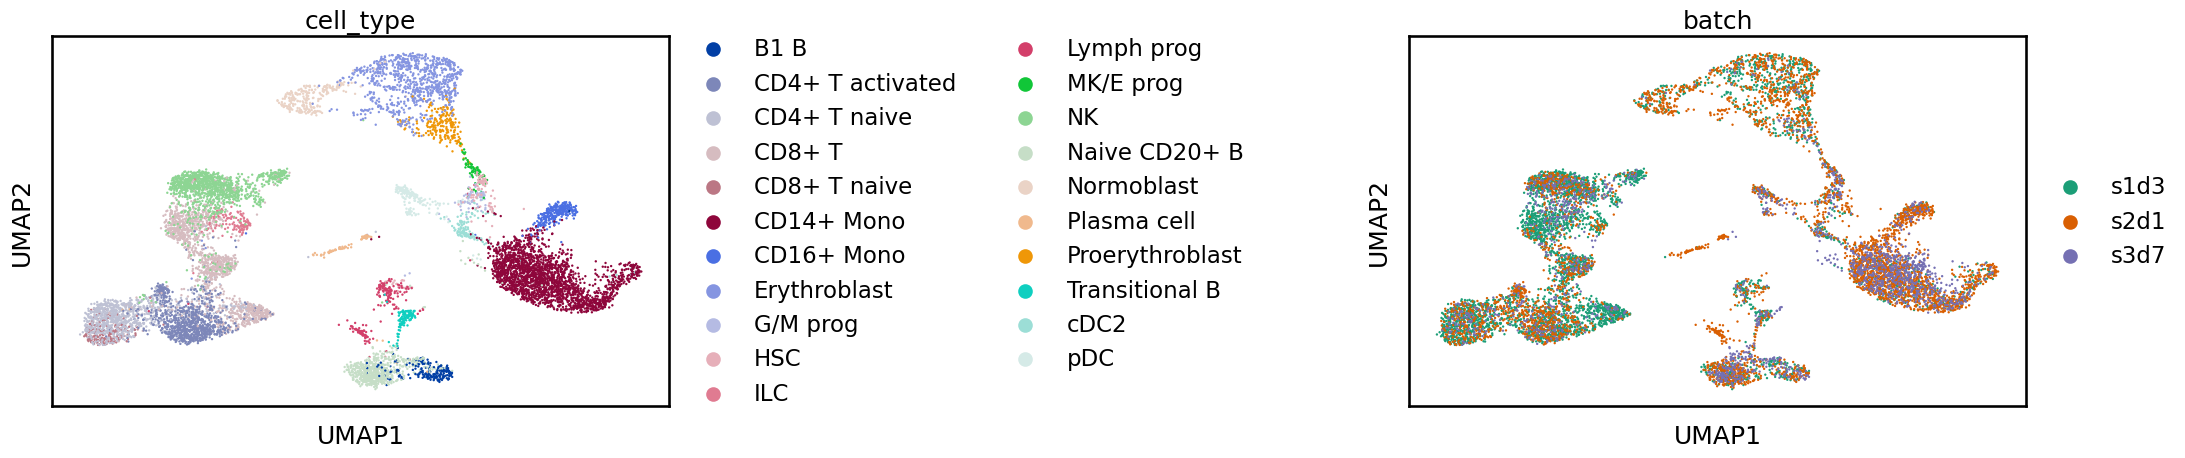

In [39]:
# Reset the batch colours because we deleted them earlier
adata_seurat.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]
sc.tl.pca(adata_seurat)
sc.pp.neighbors(adata_seurat)
sc.tl.umap(adata_seurat)
sc.pl.umap(adata_seurat, color=[label_key, batch_key], wspace=1)

# Benchmarking your own integration

Let’s run the metrics for each of the integrations we have performed above, as well as the unintegrated data (after highly variable gene selection).

In [40]:
metrics_scvi = scib.metrics.metrics_fast(
    adata, adata_scvi, batch_key, label_key, embed="X_scVI"
)
metrics_scanvi = scib.metrics.metrics_fast(
    adata, adata_scanvi, batch_key, label_key, embed="X_scANVI"
)
metrics_bbknn = scib.metrics.metrics_fast(adata, adata_bbknn, batch_key, label_key)
metrics_seurat = scib.metrics.metrics_fast(adata, adata_seurat, batch_key, label_key)
metrics_hvg = scib.metrics.metrics_fast(adata, adata_hvg, batch_key, label_key)

Silhouette score...
PC regression...


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [41]:
# an example of what one of the metrics results looks like for a single integration
# Scores are between 0 and 1, 
# where 1 is a good performance and 0 is a poor performance (scib can also return unscaled scores for some metrics if required)
metrics_hvg


,0
NMI_cluster/label,NaN
ARI_cluster/label,NaN
ASW_label,0.555775
ASW_label/batch,0.833656
PCR_batch,0.537846
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.653710
graph_conn,0.985533
kBET,NaN


In [42]:
# To compare the methods it is useful to have all the metrics results in one table. 

# Concatenate metrics results
metrics = pd.concat(
    [metrics_scvi, metrics_scanvi, metrics_bbknn, metrics_seurat, metrics_hvg],
    axis="columns",
)
# Set methods as column names
metrics = metrics.set_axis(
    ["scVI", "scANVI", "BBKNN", "Seurat", "Unintegrated"], axis="columns"
)
# Select only the fast metrics
metrics = metrics.loc[
    [
        "ASW_label",
        "ASW_label/batch",
        "PCR_batch",
        "isolated_label_silhouette",
        "graph_conn",
        "hvg_overlap",
    ],
    :,
]
# Transpose so that metrics are columns and methods are rows
metrics = metrics.T
# Remove the HVG overlap metric because it's not relevant to embedding outputs
metrics = metrics.drop(columns=["hvg_overlap"])
metrics

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn
scVI,0.569884,0.909627,0.911354,0.628802,0.980936
scANVI,0.588702,0.907423,0.872897,0.638121,0.983666
BBKNN,0.555469,0.847772,0.537846,0.641923,0.954811
Seurat,0.571231,0.915237,0.788886,0.617306,0.989366
Unintegrated,0.555775,0.833656,0.537846,0.653710,0.985533


In [43]:
metrics.style.background_gradient(cmap="Blues")

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pandas/io/formats/style.py:3560: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgbas = plt.cm.get_cmap(cmap)(norm(gmap))


,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn
scVI,0.569884,0.909627,0.911354,0.628802,0.980936
scANVI,0.588702,0.907423,0.872897,0.638121,0.983666
BBKNN,0.555469,0.847772,0.537846,0.641923,0.954811
Seurat,0.571231,0.915237,0.788886,0.617306,0.989366
Unintegrated,0.555775,0.833656,0.537846,0.653710,0.985533


In [44]:
metrics_scaled = (metrics - metrics.min()) / (metrics.max() - metrics.min())
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn
scVI,0.433762,0.931234,1.000000,0.315790,0.756026
scANVI,1.000000,0.904219,0.897037,0.571761,0.835043
BBKNN,0.000000,0.173036,0.000000,0.676211,0.000000
Seurat,0.474302,1.000000,0.672114,0.000000,1.000000
Unintegrated,0.009217,0.000000,0.000000,1.000000,0.889072


In [45]:
# The evaluation metrics can be grouped into two categories, 
# those that measure the removal of batch effects and those that measure the conservation of biological variation.
metrics_scaled["Batch"] = metrics_scaled[
    ["ASW_label/batch", "PCR_batch", "graph_conn"]
].mean(axis=1)
metrics_scaled["Bio"] = metrics_scaled[["ASW_label", "isolated_label_silhouette"]].mean(
    axis=1
)
metrics_scaled.style.background_gradient(cmap="Blues")

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pandas/io/formats/style.py:3560: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgbas = plt.cm.get_cmap(cmap)(norm(gmap))


,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,Batch,Bio
scVI,0.433762,0.931234,1.000000,0.315790,0.756026,0.895753,0.374776
scANVI,1.000000,0.904219,0.897037,0.571761,0.835043,0.878766,0.785881
BBKNN,0.000000,0.173036,0.000000,0.676211,0.000000,0.057679,0.338106
Seurat,0.474302,1.000000,0.672114,0.000000,1.000000,0.890705,0.237151
Unintegrated,0.009217,0.000000,0.000000,1.000000,0.889072,0.296357,0.504609


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1080: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = self.plt.cm.get_cmap(cmap)


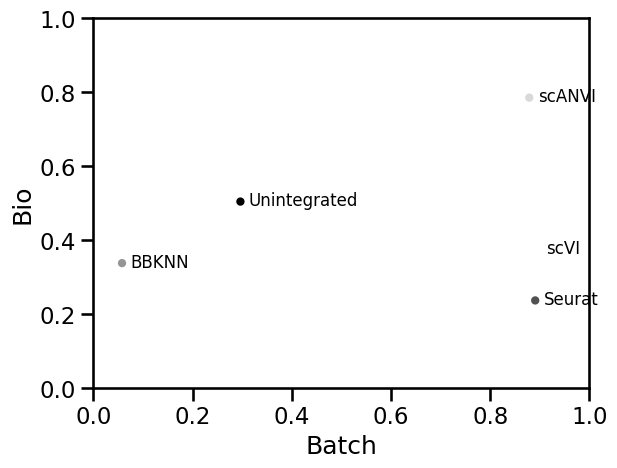

In [46]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
metrics_scaled.plot.scatter(
    x="Batch",
    y="Bio",
    c=range(len(metrics_scaled)),
    ax=ax,
)

for k, v in metrics_scaled[["Batch", "Bio"]].iterrows():
    ax.annotate(
        k,
        v,
        xytext=(6, -3),
        textcoords="offset points",
        family="sans-serif",
        fontsize=12,
    )

# In our small example scenario BBKNN is clearly the worst performer, getting the lowest scores for both batch removal and biological conservation. 
# The other three methods have similar batch correction scores with scANVI scoring highest for biological conservation followed by scVI and Seurat.

In [47]:
# To get an overall score for each method we can combine the two summary scores. 
# The scIB paper suggests a weighting of 40% batch correction and 60% biological conservation 
# but you may prefer to weight things differently depending on the priorities for your dataset.

metrics_scaled["Overall"] = 0.4 * metrics_scaled["Batch"] + 0.6 * metrics_scaled["Bio"]
metrics_scaled.style.background_gradient(cmap="Blues")

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pandas/io/formats/style.py:3560: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgbas = plt.cm.get_cmap(cmap)(norm(gmap))


,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,Batch,Bio,Overall
scVI,0.433762,0.931234,1.000000,0.315790,0.756026,0.895753,0.374776,0.583167
scANVI,1.000000,0.904219,0.897037,0.571761,0.835043,0.878766,0.785881,0.823035
BBKNN,0.000000,0.173036,0.000000,0.676211,0.000000,0.057679,0.338106,0.225935
Seurat,0.474302,1.000000,0.672114,0.000000,1.000000,0.890705,0.237151,0.498573
Unintegrated,0.009217,0.000000,0.000000,1.000000,0.889072,0.296357,0.504609,0.421308


<AxesSubplot: >

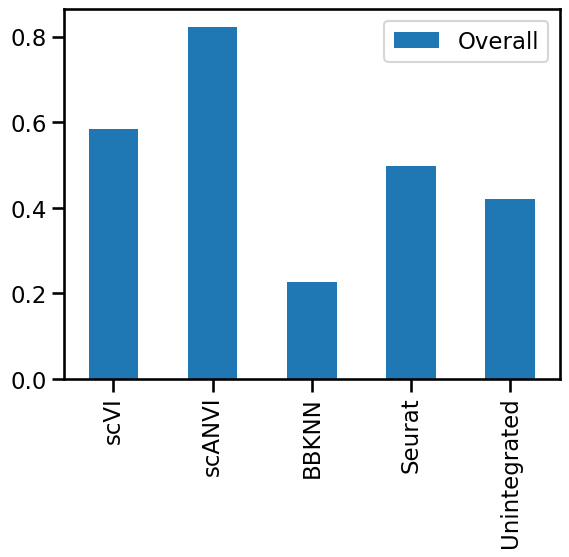

In [48]:
metrics_scaled.plot.bar(y="Overall")

# Session information

In [49]:
import session_info

session_info.show()

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing attr.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for attrs's packaging metadata.
  mod_version = _find_version(mod.__version__)


In [50]:
%%R

sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/mowp/mambaforge/envs/sc/lib/libmkl_intel_lp64.so.2

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.5-3                SingleCellExperiment_1.20.0
 [3] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [5] GenomicRanges_1.50.0        GenomeInfoDb_1.34.9        
 [7] IRanges_2.32.0              MatrixGenerics_1.10.0      
 [9] matrixStats_1.0.0           S4Vectors_